In [1]:
try:
    import google.colab  # to ensure that we are inside colab
    !pip install --upgrade --quiet phiflow==3.4
    #!pip install --upgrade --quiet git+https://github.com/tum-pbs/PhiFlow@develop
    
    # for pbdl-dataset:
    !pip install --upgrade --quiet git+https://github.com/tum-pbs/pbdl-dataset

except ImportError:
    print("This notebook is running locally, please make sure the necessary pip packages are installed.")
    pass

This notebook is running locally, please make sure the necessary pip packages are installed.


In [10]:
!pip install --upgrade --quiet git+https://github.com/tum-pbs/pbdl-dataset
!pip install --upgrade --quiet pbdl

In [2]:
import os, sys, logging, argparse, pickle, glob, random, pylab, time
from tqdm import tqdm
from phi.torch.flow import *

random.seed(42)
np.random.seed(42)

#math.seed(42) # phiflow seed (note, this can cause an error on some backends; activate if possible)
math.set_global_precision(32) # single precision

USE_CPU = 0
TORCH.set_default_device("GPU")
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if USE_CPU > 0:
    device = 'cpu'
device = torch.device(device)
print("Using device: "+str(device))

Using device: cpu


/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phiml/backend/_backend.py:265: RuntimeWarning: torch: Cannot select 'GPU' because no device of this type is available.
  warnings.warn(f"{self.name}: Cannot select '{device}' because no device of this type is available.", RuntimeWarning)


In [3]:
RE_FAC_SOL = 10/(128*128) # factor to compensate for the original scaling from the original solver-in-the-loop paper

class KarmanFlow():
    def __init__(self, domain):
        self.domain = domain

        self.vel_BcMask = self.domain.staggered_grid( HardGeometryMask( Box(y=(None, 5), x=None) ) )

        self.inflow = self.domain.scalar_grid(Box(y=(5,10), x=(25,75)) ) # scale with domain if necessary!
        self.obstacles = [Obstacle(Sphere(center=tensor([50, 50], channel(vector="y,x")), radius=10))]

    def step(self, marker_in, velocity_in, Re, res, buoyancy_factor=0, dt=1.0):
        velocity = velocity_in
        marker   = marker_in
        Re_phiflow = Re / RE_FAC_SOL # rescale for phiflow

        # viscosity
        velocity = phi.flow.diffuse.explicit(u=velocity, diffusivity=1.0/Re_phiflow*dt*res*res, dt=dt)

        # inflow boundary conditions
        velocity = velocity*(1.0 - self.vel_BcMask) + self.vel_BcMask * (1,0)

        # advection
        marker = advect.semi_lagrangian(marker+ 1. * self.inflow, velocity, dt=dt)
        velocity = advected_velocity = advect.semi_lagrangian(velocity, velocity, dt=dt)

        # mass conservation (pressure solve)
        pressure = None
        velocity, pressure = fluid.make_incompressible(velocity, self.obstacles, Solve('CG', 1e-3))
        self.solve_info = { 'pressure': pressure, 'advected_velocity': advected_velocity }

        return [marker, velocity]

In [4]:
layers = [32,32,32] # small
#layers = [32,48,48,48,32] # uncomment for a somewhat larger and deeper network
#network = conv_net(in_channels=3,out_channels=2,layers=layers) # a simpler variant
network = res_net(in_channels=3,out_channels=2,layers=layers)
print(network)

# reinit
import torch.nn as nn
for m in network.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight, gain=0.1)

print("Total number of trainable parameters: "+ str( sum(p.numel() for p in network.parameters()) ))

ResNet(
  (Res_in): ResNetBlock(
    (sample_input): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn_sample): Identity()
    (bn1): Identity()
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): Identity()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (Res1): ResNetBlock(
    (sample_input): Identity()
    (bn_sample): Identity()
    (bn1): Identity()
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): Identity()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (Res2): ResNetBlock(
    (sample_input): Identity()
    (bn_sample): Identity()
    (bn1): Identity()
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): Identity()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (Res_out): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
)
Total number of trainable

In [5]:
def to_phiflow(batch):
    vx = batch[:,1,:-1,:-1]
    vy = batch[:,2,:,:] # fine

    #print("v_dims "+str([vx.shape,vy.shape])) # example for debugging
    # v_dims should be vx [torch.Size([B, 64, 31]),  vy torch.Size([B, 65, 32])]

    vel = domain.staggered_grid( math.stack( [
                            math.tensor(vy, math.batch('batch'), math.spatial('y, x')),
                            math.tensor(vx, math.batch('batch'), math.spatial('y, x')),
                        ], math.dual(vector="y,x")
                    ) )
    return vel

def to_pytorch(marker_vel, Re):
    # align the sides the staggered velocity grid making its size the same as the centered grid
    grid = math.stack(
        [
            math.pad( marker_vel[1].vector['x'].values, {'x':(0,1)} , math.extrapolation.ZERO), # x component
            marker_vel[1].vector['y'].y[:-1].values,                                            # y component
            math.ones(marker_vel[0].shape)*Re                                                   # constant Re
        ],
        math.channel('channels')
    ).native(order='batch,channels,y,x')
    return grid

def to_solver(inputs):
    marker_in = inputs[:,0,:-1,:]
    marker_in = domain.scalar_grid( math.tensor(marker_in, math.batch('batch'), math.spatial('y, x')) )
    v_in = to_phiflow(inputs)
    Re = math.tensor(inputs[0,3, 0,0].detach()) # Scalar , get first index 0,0

    Re_norm = (Re - math.tensor(DATA_RE_MEAN)) / math.tensor(DATA_RE_STD)
    Re_norm = float(Re_norm.native().detach()) # we just need a single number

    return marker_in, v_in, Re, Re_norm

In [6]:
LEARNING_RATE = 1e-3
optimizer = adam(network, LEARNING_RATE)

# one of the most crucial parameters: how many simulation steps to look into the future in each training step
MSTEPS = 4

BATCH_SIZE = 3

In [11]:
import pbdl
import pbdl.torch.loader

dataloader = pbdl.torch.loader.Dataloader("solver-in-the-loop-wake-flow", MSTEPS, shuffle=True, sel_sims=[0,1,2,3,4,5],
                                          batch_size=BATCH_SIZE, normalize_const="std", normalize_data="std", intermediate_time_steps=True)

# workaround for using un-normalized and normalized values in one script:
#    save the normalization constants of the Reynolds number conditioning , then turn off (norm=None);
#    the Re values will be normalized manually later on
DATA_RE_MEAN = dataloader.dataset.norm_strat_const.const_mean[0][0]
DATA_RE_STD  = dataloader.dataset.norm_strat_const.const_std[0][0]
print([DATA_RE_MEAN,DATA_RE_STD])
dataloader.dataset.norm_strat_const = None
dataloader.dataset.norm_strat_data = None

download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%6m
Success: Loaded solver-in-the-loop-wake-flow with 6 simulations (6 selected) and 496 samples each.
Info: No precomputed normalization data found (or not complete). Calculating data...
[1025.390625, 1057.4417884622908]


In [8]:
# this is the actual resolution in terms of cells for phiflow (not too crucial)
SOURCE_RES = [64,32]

# this is the physical size in terms of abstract units for the bounding box of the domain (it's important for conversions between computational and physical units)
LENGTH = 100.

# for readability
from phi.physics._boundaries import Domain, OPEN, STICKY as CLOSED

BNDS = {
    'y':(phi.physics._boundaries.OPEN,  phi.physics._boundaries.OPEN) ,
    'x':(phi.physics._boundaries.STICKY,phi.physics._boundaries.STICKY)
}

domain = phi.physics._boundaries.Domain(y=SOURCE_RES[0], x=SOURCE_RES[1], boundaries=BNDS, bounds=Box(y=2*LENGTH, x=LENGTH))
simulator = KarmanFlow(domain=domain)

/var/folders/z7/kf7_7b9n01b71nv2r1zvpqvm0000gn/T/ipykernel_79299/1641432920.py:8: FutureWarning: Domain (phi.physics._boundaries) is deprecated and will be removed in a future release.
Please create grids directly, replacing the domain with a dict, e.g.
    domain = dict(x=64, y=128, bounds=Box(x=1, y=1))
    grid = CenteredGrid(0, **domain)
  from phi.physics._boundaries import Domain, OPEN, STICKY as CLOSED
/var/folders/z7/kf7_7b9n01b71nv2r1zvpqvm0000gn/T/ipykernel_79299/1641432920.py:15: DeprecationWarning: Domain is deprecated and will be removed in a future release. Use a dict instead, e.g. CenteredGrid(values, extrapolation, **domain_dict)
  domain = phi.physics._boundaries.Domain(y=SOURCE_RES[0], x=SOURCE_RES[1], boundaries=BNDS, bounds=Box(y=2*LENGTH, x=LENGTH))
/var/folders/z7/kf7_7b9n01b71nv2r1zvpqvm0000gn/T/ipykernel_79299/1641432920.py:15: FutureWarning: Domain is deprecated and will be removed in a future release. Use a dict instead, e.g. CenteredGrid(values, extrapolation

In [12]:
@jit_compile
def simulation_step(marker,velocity,Re,resolution):
    m,v = simulator.step(
        marker_in=marker,
        velocity_in=velocity,
        Re=Re, res=resolution
    )
    return m,v

In [13]:
def training_step(inputs_targets):
    [inputs, targets] = inputs_targets
    marker_in, v_in, Re, Re_norm = to_solver(inputs)
    prediction = [ [marker_in,v_in] ]
    loss = 0

    for i in range(MSTEPS):
        m2,v2 = simulation_step(
            marker=prediction[-1][0],
            velocity=prediction[-1][1],
            Re=Re, resolution=SOURCE_RES[1]
        )

        net_in = to_pytorch([m2,v2],Re_norm)
        net_out = network(net_in)

        cy = net_out[:,1,:,:] # pad y
        cy = torch.nn.functional.pad(input=cy, pad=(0,0, 0,1), mode='constant', value=0)
        cx = net_out[:,0,:,:-1]

        v_corr = domain.staggered_grid( math.stack( [
                            math.tensor(cy, math.batch('batch'), math.spatial('y, x')),
                            math.tensor(cx, math.batch('batch'), math.spatial('y, x')),
                        ], math.dual(vector="y,x")
                    ) )

        prediction += [ [domain.scalar_grid(m2) , v2 + v_corr] ]
        vdiff = prediction[-1][1] - to_phiflow(targets[:,i,...])
        loss += field.l2_loss(vdiff)

    return loss, prediction

In [14]:
EPOCHS = 5

pbar = tqdm(initial=0, total=EPOCHS*len(dataloader), ncols=96)

for epoch in range(EPOCHS):
    for b, (input_cpu, targets_cpu) in enumerate(dataloader):
        input = torch.tensor(input_cpu, dtype=torch.float32).to(device);
        targets = torch.tensor(targets_cpu, dtype=torch.float32).to(device)

        loss, prediction = update_weights(network, optimizer, training_step, [input, targets])

        pbar.set_description("loss "+str(np.sum(loss.numpy("batch"))), refresh=False); pbar.update(1)

    torch.save(network.state_dict(), "net-"+str(epoch)+".pickle")

pbar.close()

  0%|                                                                  | 0/4960 [00:00<?, ?it/s]/var/folders/z7/kf7_7b9n01b71nv2r1zvpqvm0000gn/T/ipykernel_79299/4154370188.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input_cpu, dtype=torch.float32).to(device);
/var/folders/z7/kf7_7b9n01b71nv2r1zvpqvm0000gn/T/ipykernel_79299/4154370188.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets_cpu, dtype=torch.float32).to(device)
/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phiml/math/_optimize.py:640: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify 

In [15]:
del dataloader # close hdf5 file handle

# get new & unseen test data
dataloader_test = pbdl.torch.loader.Dataloader("solver-in-the-loop-wake-flow", 200, batch_size=1, shuffle=True, sel_sims=[6,7,8,9],
                                          normalize=False, intermediate_time_steps=True)
# optionally load
if False:
    fn = "net-"+str(EPOCHS-1)+".pickle" # load last
    network.load_state_dict(torch.load(fn, map_location=device, weights_only=True))
    print("Loaded "+fn)

download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%6m
Success: Loaded solver-in-the-loop-wake-flow with 10 simulations (4 selected) and 300 samples each.


In [16]:
def run_sim(inputs, targets, steps, network=None):
    marker_in, v_in, Re, Re_norm = to_solver(inputs)

    simtype = "With corr."
    if (network==None): simtype = "Sim. only"
    print("Running test with Re="+str(Re)+", "+simtype)

    prediction = [ [marker_in,v_in] ]
    correction = [ [marker_in,v_in] ]
    refs = [ v_in ]
    errors = []

    for i in tqdm(range(steps), desc=simtype, ncols = 64):
        marker_sim,v_sim = simulation_step(
            marker=prediction[-1][0],
            velocity=prediction[-1][1],
            Re=Re, resolution=SOURCE_RES[1]  # take Re from constant field
        )

        if network: # run hybrid solver with trained Neural op
            net_in = to_pytorch([marker_sim,v_sim],Re_norm)
            net_out = network(net_in)

            cy = net_out[:,1,:,:] # pad y
            cy = torch.nn.functional.pad(input=cy, pad=(0,0, 0,1), mode='constant', value=0)
            cx = net_out[:,0,:,:-1]

            v_corr = domain.staggered_grid( math.stack( [
                                math.tensor(cy, math.batch('batch'), math.spatial('y, x')),
                                math.tensor(cx, math.batch('batch'), math.spatial('y, x')),
                            ], math.dual(vector="y,x")
                        ) )

            prediction += [ [domain.scalar_grid(marker_sim) , v_sim + v_corr] ]
            correction += [ [domain.scalar_grid(marker_sim) , v_corr] ]

        else: # only low-fidelity solver
            prediction += [ [domain.scalar_grid(marker_sim) , v_sim ] ]

        refs += [to_phiflow(targets[:,i,...])]
        vdiff = prediction[i][1] - refs[-1]

        error_phi = field.l1_loss(vdiff)
        errors += [float( error_phi.native("batch")[0] / field.l1_loss(refs[-1]).native("batch")[0] )]

    return errors, prediction, refs, correction

In [17]:
# get a sample
(input_cpu, targets_cpu) = next(iter(dataloader_test))
input = torch.tensor(input_cpu, dtype=torch.float32).to(device)
targets = torch.tensor(targets_cpu, dtype=torch.float32).to(device)
print("Re ",math.tensor(input[0,3, 0,0].detach()))

Re  4687.5


/var/folders/z7/kf7_7b9n01b71nv2r1zvpqvm0000gn/T/ipykernel_79299/1514360431.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input_cpu, dtype=torch.float32).to(device)
/var/folders/z7/kf7_7b9n01b71nv2r1zvpqvm0000gn/T/ipykernel_79299/1514360431.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets_cpu, dtype=torch.float32).to(device)


In [18]:
ROLLOUT_STEPS = 100

err_lowfid_only, prediction_lowfid_only, refs, _   = run_sim(input, targets, ROLLOUT_STEPS)
err_corrected,   prediction_corrected  , _ , corrs = run_sim(input, targets, ROLLOUT_STEPS, network)
print("\n Rel. L2 errors: low-fidelity:", float(np.mean(err_lowfid_only))," corrected:", float(np.mean(err_corrected)) )

Running test with Re=4687.5, Sim. only


Sim. only:   0%|                        | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phiml/math/_optimize.py:640: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")
/opt/anaconda3/envs/sfml/lib/python3.12/site-packages/phiml/math/_optimize.py:640: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")
Sim. only: 100%|██████████████| 100/100 [00:03<00:00, 30.73it/s]


Running test with Re=4687.5, With corr.


With corr.:   0%|                       | 0/100 [00:00<?, ?it/s]/var/folders/z7/kf7_7b9n01b71nv2r1zvpqvm0000gn/T/ipykernel_79299/523707572.py:44: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)
  errors += [float( error_phi.native("batch")[0] / field.l1_loss(refs[-1]).native("batch")[0] )]
With corr.: 100%|█████████████| 100/100 [00:04<00:00, 21.72it/s]


 Rel. L2 errors: low-fidelity: 0.3085068943910301  corrected: 0.2913806295208633


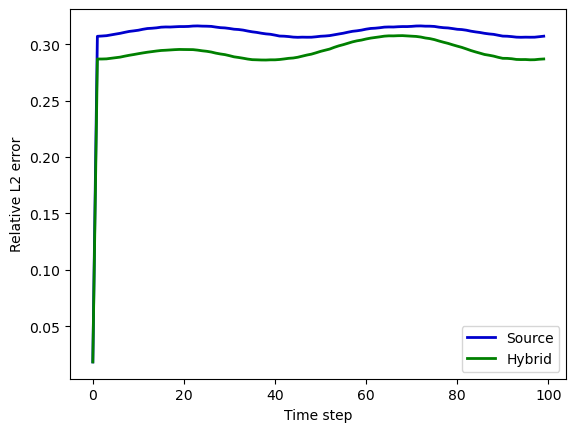

In [19]:
fig = pylab.figure().gca()
pltx = np.linspace(0,ROLLOUT_STEPS-1,ROLLOUT_STEPS)
fig.plot(pltx, err_lowfid_only, lw=2, color='mediumblue', label='Source')
fig.plot(pltx, err_corrected,   lw=2, color='green', label='Hybrid')
pylab.xlabel('Time step'); pylab.ylabel('Relative L2 error'); fig.legend()

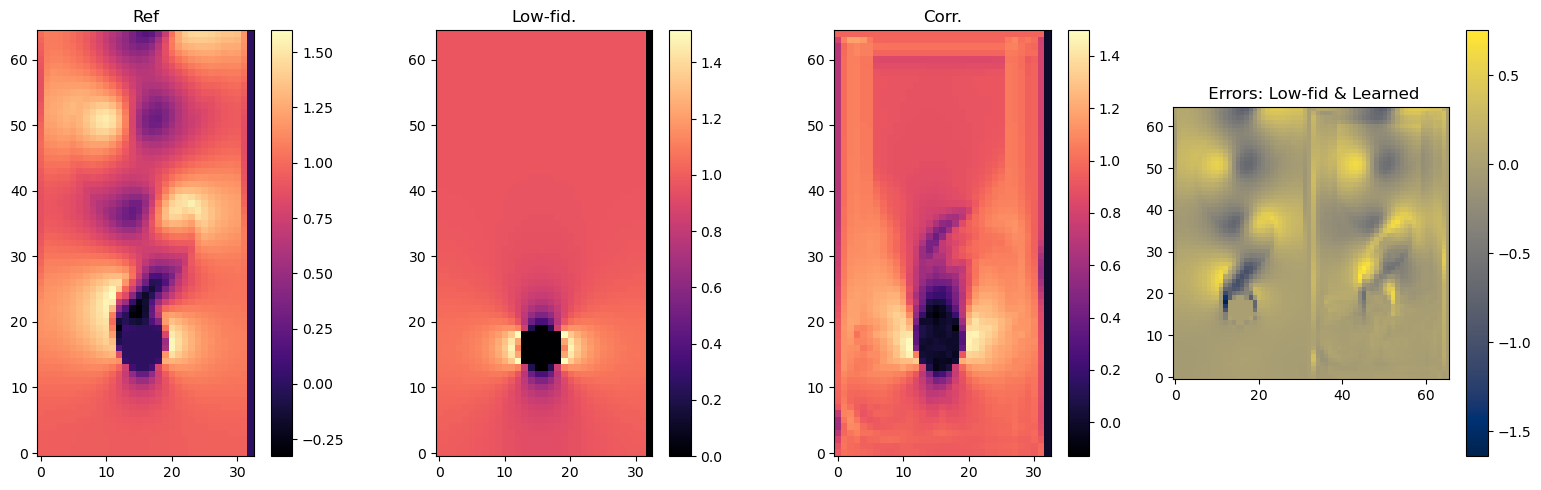

In [20]:
# which step from which batch to show , by default shows last step from first case
STEP = ROLLOUT_STEPS
BATCH = 0
NUM_SHOW = 4
PRINT_STATS = False # optional, print statistics

fig, axes = pylab.subplots(1, 4, figsize=(16, 5))
i = 0

v = refs[STEP].staggered_tensor().numpy('batch,y,x,vector')[BATCH,:,:,0]
if PRINT_STATS: print(["reference ", BATCH, i, np.mean(v),  np.min(v) ,  np.max(v)])
axes[i].set_title(f"Ref")
im=axes[i].imshow( v , origin='lower', cmap='magma') ;
pylab.colorbar(im) ; i=i+1; vy_ref=v

v = prediction_lowfid_only[STEP][1].staggered_tensor().numpy('batch,y,x,vector')[BATCH,:,:,0]
if PRINT_STATS: print(["low-fid. ", BATCH, i, np.mean(v),  np.min(v) ,  np.max(v)])
axes[i].set_title(f"Low-fid.")
im=axes[i].imshow( v , origin='lower', cmap='magma') ;
pylab.colorbar(im) ; i=i+1; vy_lowfid=v

v = prediction_corrected[STEP][1].staggered_tensor().numpy('batch,y,x,vector')[BATCH,:,:,0]
if PRINT_STATS: print(["corrected", BATCH, i, np.mean(v),  np.min(v) ,  np.max(v)])
axes[i].set_title(f"Corr.")
im=axes[i].imshow( v , origin='lower', cmap='magma') ;
pylab.colorbar(im) ; i=i+1; vy_corr=v

# show error side by side
err_lf   = vy_ref - vy_lowfid
err_corr = vy_ref - vy_corr
v = np.concatenate([err_lf,err_corr], axis=1)
axes[i].set_title(f" Errors: Low-fid & Learned")
im=axes[i].imshow( v , origin='lower', cmap='cividis') ;
pylab.colorbar(im) ; i=i+1

pylab.tight_layout()